# Reinforcement learning for Easy21

In [1]:
import numpy as np
from random import random
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def new_card():
    value = int(random() * 10) + 1
    if random() < (2/3):
        return value
    else:
        return -value

In [46]:
def step(dealer_card, player_sum, action):
    if action == "hit":
        player_sum += new_card()
        if (player_sum < 1 or player_sum > 21):
            return (-1, -1, -1)
        else:
            return (dealer_card, player_sum, 0)
    if action == "stick":
        while True:
            if (dealer_card > player_sum):
                return (-1, -1, -1)
            dealer_card += new_card()
            if (dealer_card < 1 or dealer_card > 21):
                return (-1, -1, 1)
            if (dealer_card >= 17 and dealer_card == player_sum):
                return (-1, -1, 0)
    print("Unknown action.")

## Monte Carlo learning

In [22]:
def initiate_q():
    return np.zeros((10, 21, 2))

def e_greedy(dealer_card, player_sum, q, e):
    if random() < e or q[dealer_card, player_sum, 0] == q[dealer_card, player_sum, 0]:
        if random() < 0.5:
            return "stick"
        else:
            return "hit"
    if q[dealer_card, player_sum, 0] > q[dealer_card, player_sum, 1]:
        return "stick"
    else:
        return "hit"

def train_mc(episodes):
    n0 = 100
    
    q_mc = initiate_q()
    visited_action = initiate_q()
    
    for i in range(episodes):        
        dealer_card = abs(new_card())
        player_sum = abs(new_card())
        
        history = []
        
        while dealer_card != -1:
            e = n0 / (n0 + np.sum(visited_action, axis = 2)[dealer_card - 1, player_sum - 1])
            action = e_greedy(dealer_card - 1, player_sum - 1, q_mc, e)
            
            if action == "stick":
                action_int = 0
            if action == "hit":
                action_int = 1
            
            visited_action[dealer_card - 1, player_sum - 1, action_int] += 1         
            history.append((dealer_card - 1, player_sum - 1, action_int))
            
            dealer_card, player_sum, reward = step(dealer_card, player_sum, action)
                    
        for event in history:
            current_q = q_mc[event]
            q_mc[event] = current_q + 1 / visited_action[event] * (reward - current_q)
            
    return q_mc

In [50]:
# Very slow! Uncomment to run and save your own version

# q_mc = train_mc(10000000)
# pickle.dump(q_mc, open("q_star.p", "wb"))

q_mc = pickle.load(open("q_star.p", "rb"))

In [6]:
def draw_q(q):
    fig = plt.figure()
    ax = Axes3D(fig)

    X = np.arange(1, 11).tolist()
    Y = np.arange(1, 22).tolist()
    X, Y = np.meshgrid(X, Y)
    Z = np.max(q, axis = 2)[X - 1,Y - 1]

    ax.plot_wireframe(X, Y, Z)

    plt.show()

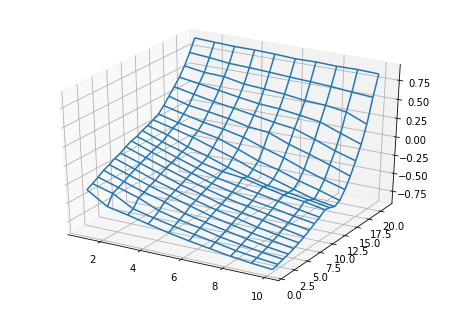

In [53]:
draw_q(q_mc)

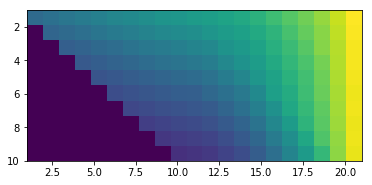

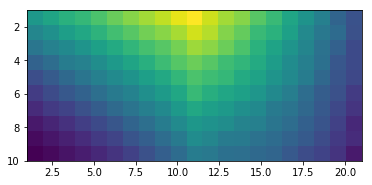

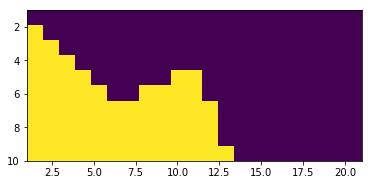

In [52]:
plt.imshow(q_mc[:,:,0], extent = [1, 21, 10, 1])
plt.show()

plt.imshow(q_mc[:,:,1], extent = [1, 21, 10, 1])
plt.show()

optimal_policy = np.argmax(q_mc, axis = 2)

plt.imshow(optimal_policy, extent = [1, 21, 10, 1])
plt.show()

## Sarsa learning

In [9]:
def train_sarsa(lambd, episodes):
    n0 = 100
    
    q_sarsa = initiate_q()
    visited_action = initiate_q()
    
    for i in range(episodes):        
        eligibility = initiate_q()
        
        dealer_card = abs(new_card())
        player_sum = abs(new_card())
        
        e = n0 / (n0 + np.sum(visited_action, axis = 2)[dealer_card - 1, player_sum - 1])
        action = e_greedy(dealer_card - 1, player_sum - 1, q_sarsa, e)
        
        while dealer_card != -1:
                
            if action == "stick":
                action_int = 0
            if action == "hit":
                action_int = 1
                
            dealer_card2, player_sum2, reward = step(dealer_card, player_sum, action)
            
            e = n0 / (n0 + np.sum(visited_action, axis = 2)[dealer_card2 - 1, player_sum2 - 1])
            action2 = e_greedy(dealer_card2 - 1, player_sum2 - 1, q_sarsa, e)
            
            if action2 == "stick":
                action_int2 = 0
            if action2 == "hit":
                action_int2 = 1
            
            q_s2a2 = q_sarsa[dealer_card2 - 1, player_sum2 - 1, action_int2]
            q_sa = q_sarsa[dealer_card - 1, player_sum - 1, action_int]
            delta = reward + q_s2a2 - q_sa
            
            eligibility[dealer_card - 1, player_sum - 1, action_int] += 1
            
            visited_action[dealer_card - 1, player_sum - 1, action_int] += 1
            
            alpha = 1 / visited_action[dealer_card - 1, player_sum - 1, action_int]
            
            q_sarsa += alpha * delta * eligibility                                                                         
                                                                                                                                                                        
            eligibility *= lambd
            
            dealer_card = dealer_card2
            player_sum = player_sum2
            action = action2
                          
    return q_sarsa

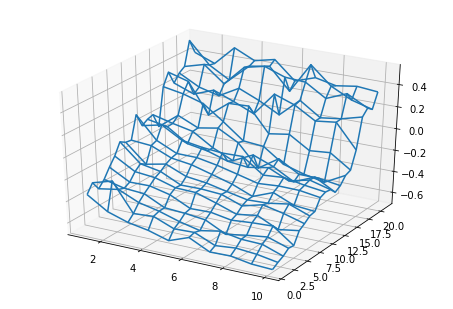

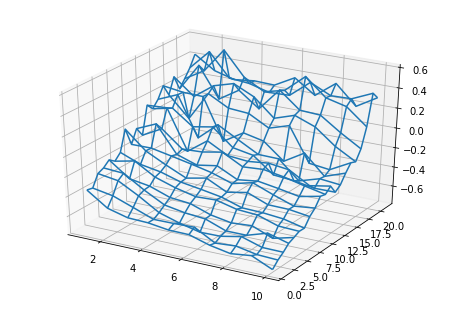

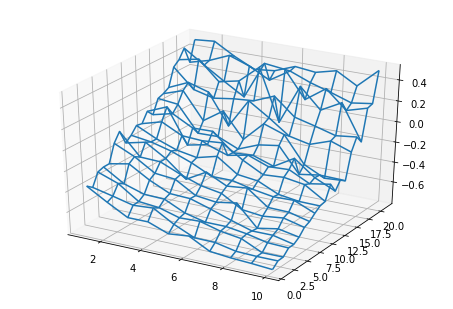

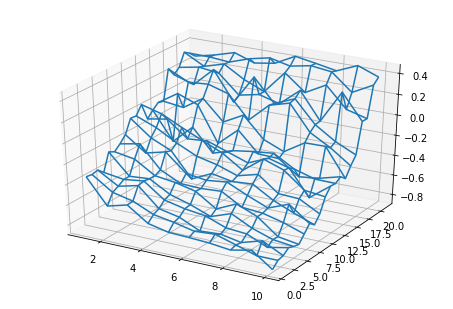

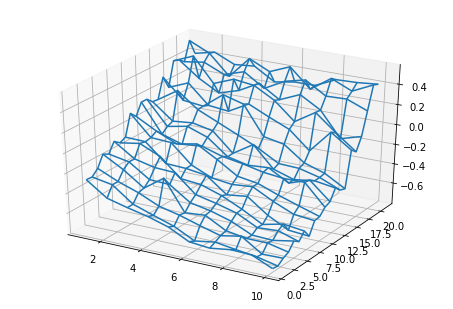

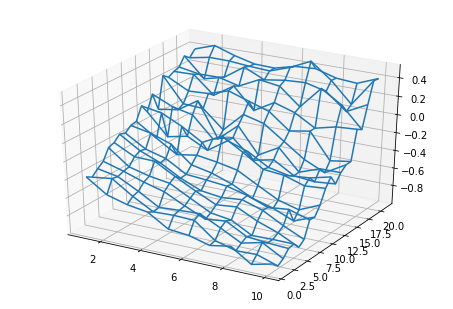

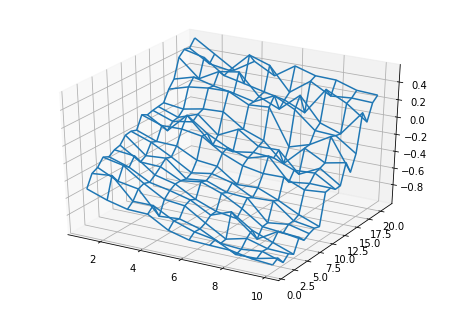

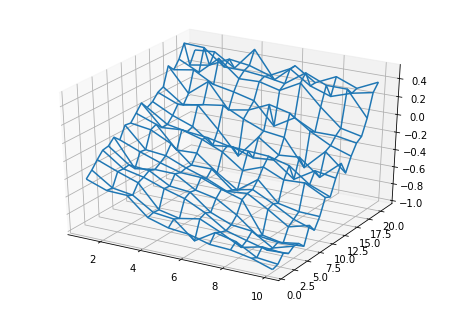

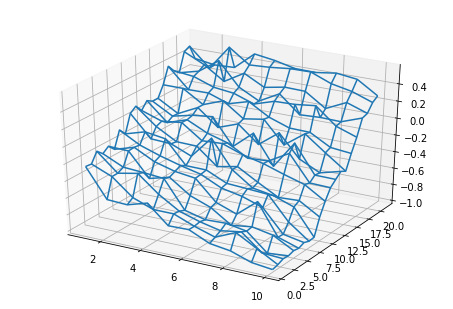

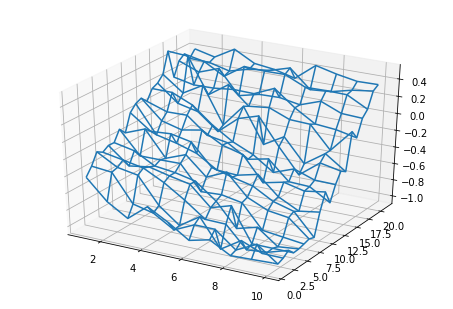

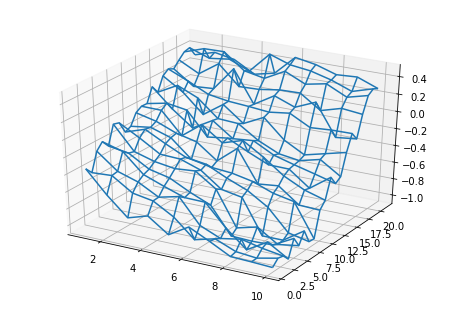

In [54]:
squared_errors = []
variances = []

for lambd in np.arange(0, 1.1, 0.1):
    sarsas = []
    for n in range(0, 50):
        q_sarsa = train_sarsa(lambd, 1000)
        sarsas.append(q_sarsa)
    draw_q(np.mean(sarsas, axis = 0))
    squared_errors.append(np.sum(np.square(sarsas - q_mc), axis = (1, 2, 3)))

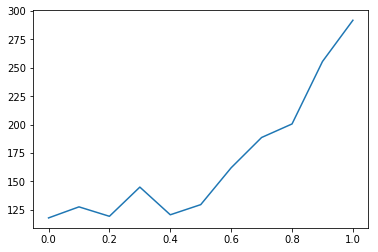

In [56]:
plt.plot(np.arange(0, 1.1, 0.1), np.mean(squared_errors, axis = 1))
plt.show()